In [2]:
#import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt
import requests
import collections
import re
import json
import glob
import math
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
from pandas.io.json import json_normalize
from scipy.spatial.distance import cdist, pdist, squareform
import pandas.tseries.holiday as hol
from sklearn.linear_model import LinearRegression
from pygam import LinearGAM, LogisticGAM, s, f
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

%matplotlib inline

In [3]:
station_zip = pd.read_csv("../Data_processed/station_with_zipzone.csv")

In [4]:
station_zip.head()

,Unnamed: 0,ID,Station,Latitude,Longitude,Municipality,Current_Bikes,Empty_Docks,Num_of_Docks,zip,zone
0,0,3,Colleges of the Fenway - Fenway at Avenue Loui...,42.340115,-71.100619,Boston,11,0,11,2115,0
1,1,4,Tremont St at E Berkeley St,42.345392,-71.069616,Boston,8,5,13,2116,0
2,2,5,Northeastern University - North Parking Lot,42.341814,-71.090179,Boston,4,5,9,2115,0
3,3,6,Cambridge St at Joy St,42.361212,-71.065306,Boston,10,2,12,2114,0
4,4,7,Fan Pier,42.353391,-71.044571,Boston,1,14,15,2210,0


In [6]:
MBTA_subway = pd.read_csv("../Data_processed/MBTA_subway.csv")

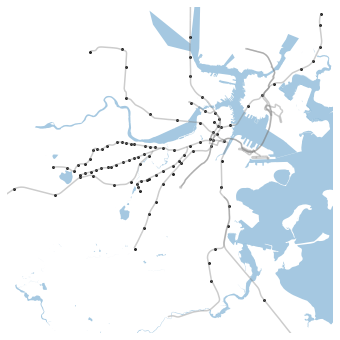

In [14]:
crs={'init':'epsg:4326'}
geometry=[Point(xy) for xy in zip(MBTA_subway.stop_lon, MBTA_subway.stop_lat)]
MBTA_subway_geo=gpd.GeoDataFrame(MBTA_subway, crs=crs, geometry = geometry).to_crs(epsg=26986)
fig, ax=plt.subplots(figsize=(6, 6))
ax.set_xlim([225000, 242500])
ax.set_ylim([890000, 907500])

metroarc= gpd.read_file("../Data_raw/Shapefiles/mbta_rapid_transit/MBTA_ARC.shp")
metroarc.plot(ax=ax, alpha=0.4, color="grey")
waterpoly = gpd.read_file("../Data_raw/Shapefiles/Hydrography_Polygon_(1)/Hydrography_Polygon.shp").to_crs(epsg=26986)
waterpoly.plot(ax=ax, alpha=0.4)

MBTA_subway_geo.plot(ax=ax, color="black", alpha=0.8, markersize=4)
_=plt.axis('off')

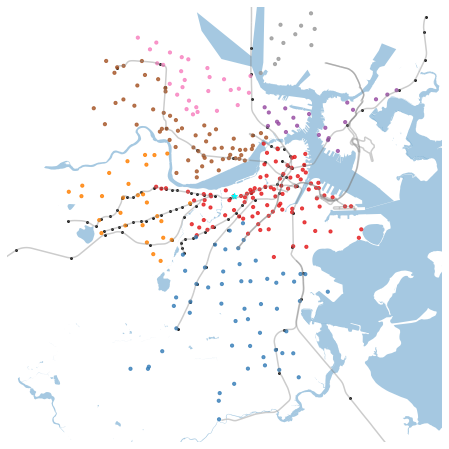

In [15]:
# WITH DISTRICT
crs={'init':'epsg:4326'}

geometry=[Point(xy) for xy in zip(station_zip.Longitude, station_zip.Latitude)]
data_geo=gpd.GeoDataFrame(station_zip, crs=crs, geometry = geometry).to_crs(epsg=26986)
fig, ax=plt.subplots(figsize=(8, 8))
ax.set_xlim([225000, 242500])
ax.set_ylim([890000, 907500])

metroarc= gpd.read_file("../Data_raw/Shapefiles/mbta_rapid_transit/MBTA_ARC.shp")
metroarc.plot(ax=ax, alpha=0.4, color="grey")
waterpoly = gpd.read_file("../Data_raw/Shapefiles/Hydrography_Polygon_(1)/Hydrography_Polygon.shp").to_crs(epsg=26986)
waterpoly.plot(ax=ax, alpha=0.4)

MBTA_subway_geo.plot(ax=ax, color="black", alpha=0.8, markersize=4)

_=data_geo.plot(column="zone", cmap="Set1", ax=ax,  alpha=0.8, markersize=10)
_=plt.axis('off')

# bikecenter
# !!! Run this last line after defining bikecenter !!! 
data_geo[data_geo.ID==52].plot(ax=ax,color="cyan", marker="*")


In [16]:
trip_simp = pd.read_csv("../Data_processed/trip_simp.csv")

In [17]:
trip_simp.head()

,Unnamed: 0,start_station_id,end_station_id,starttime,stoptime,tripduration,bikeid,counting
0,0,22,60,2017-07-01 00:00:21,2017-07-01 00:08:05,463,706,1
1,1,22,52,2017-07-01 00:00:30,2017-07-01 00:12:00,689,565,1
2,2,41,381,2017-07-01 00:01:16,2017-07-01 00:24:14,1377,567,1
3,3,116,116,2017-07-01 00:01:28,2017-07-01 00:02:43,74,484,1
4,4,120,52,2017-07-01 00:02:06,2017-07-01 00:10:07,480,48,1


In [11]:
trip_simp = pd.read_csv("../Data_processed/trip_simp.csv",parse_dates=["starttime", "stoptime"], index_col=0)
station_zip = pd.read_csv("../Data_processed/station_with_zipzone.csv", index_col=0)
tripmonth = pd.read_csv("../Data_processed/tripmonth.csv")
data=pd.merge(station_zip[["ID", "Latitude", "Longitude", "Num_of_Docks", "zip", "zone"]], tripmonth[["start_station_id", "Num_Op_Months", "Ave_Trips_Per_Month"]], 
                how="left", left_on="ID", right_on="start_station_id").drop("start_station_id", axis=1)


In [12]:
# Aggregate by hour
trip_simp['start_hour_stamp'] = trip_simp["starttime"].dt.hour
trip_simp['stop_hour_stamp'] = trip_simp["stoptime"].dt.hour
trip_right_stations=trip_simp[(trip_simp.start_station_id.isin(data.ID.values)) & trip_simp.end_station_id.isin(data.ID.values)]
starthours=pd.pivot_table(trip_right_stations, values="counting", index="start_station_id", columns="start_hour_stamp", aggfunc=np.sum)
endhours=pd.pivot_table(trip_right_stations, values="counting", index="end_station_id", columns="stop_hour_stamp", aggfunc=np.sum)

In [13]:
time_df=starthours.subtract(endhours).fillna(0).reset_index()
time_df.rename(columns={"start_station_id":"ID"}, inplace=True)
time_df_std=time_df.iloc[:, 1:].values.flatten().std()
time_df_med=np.median(time_df.iloc[:, 1:].values.flatten())
time_df.iloc[:, 1:] = (time_df.iloc[:, 1:]-time_df_med)/time_df_std

In [16]:
time_df.rename(columns={"index":"ID"}, inplace=True)

/Users/kkim14/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


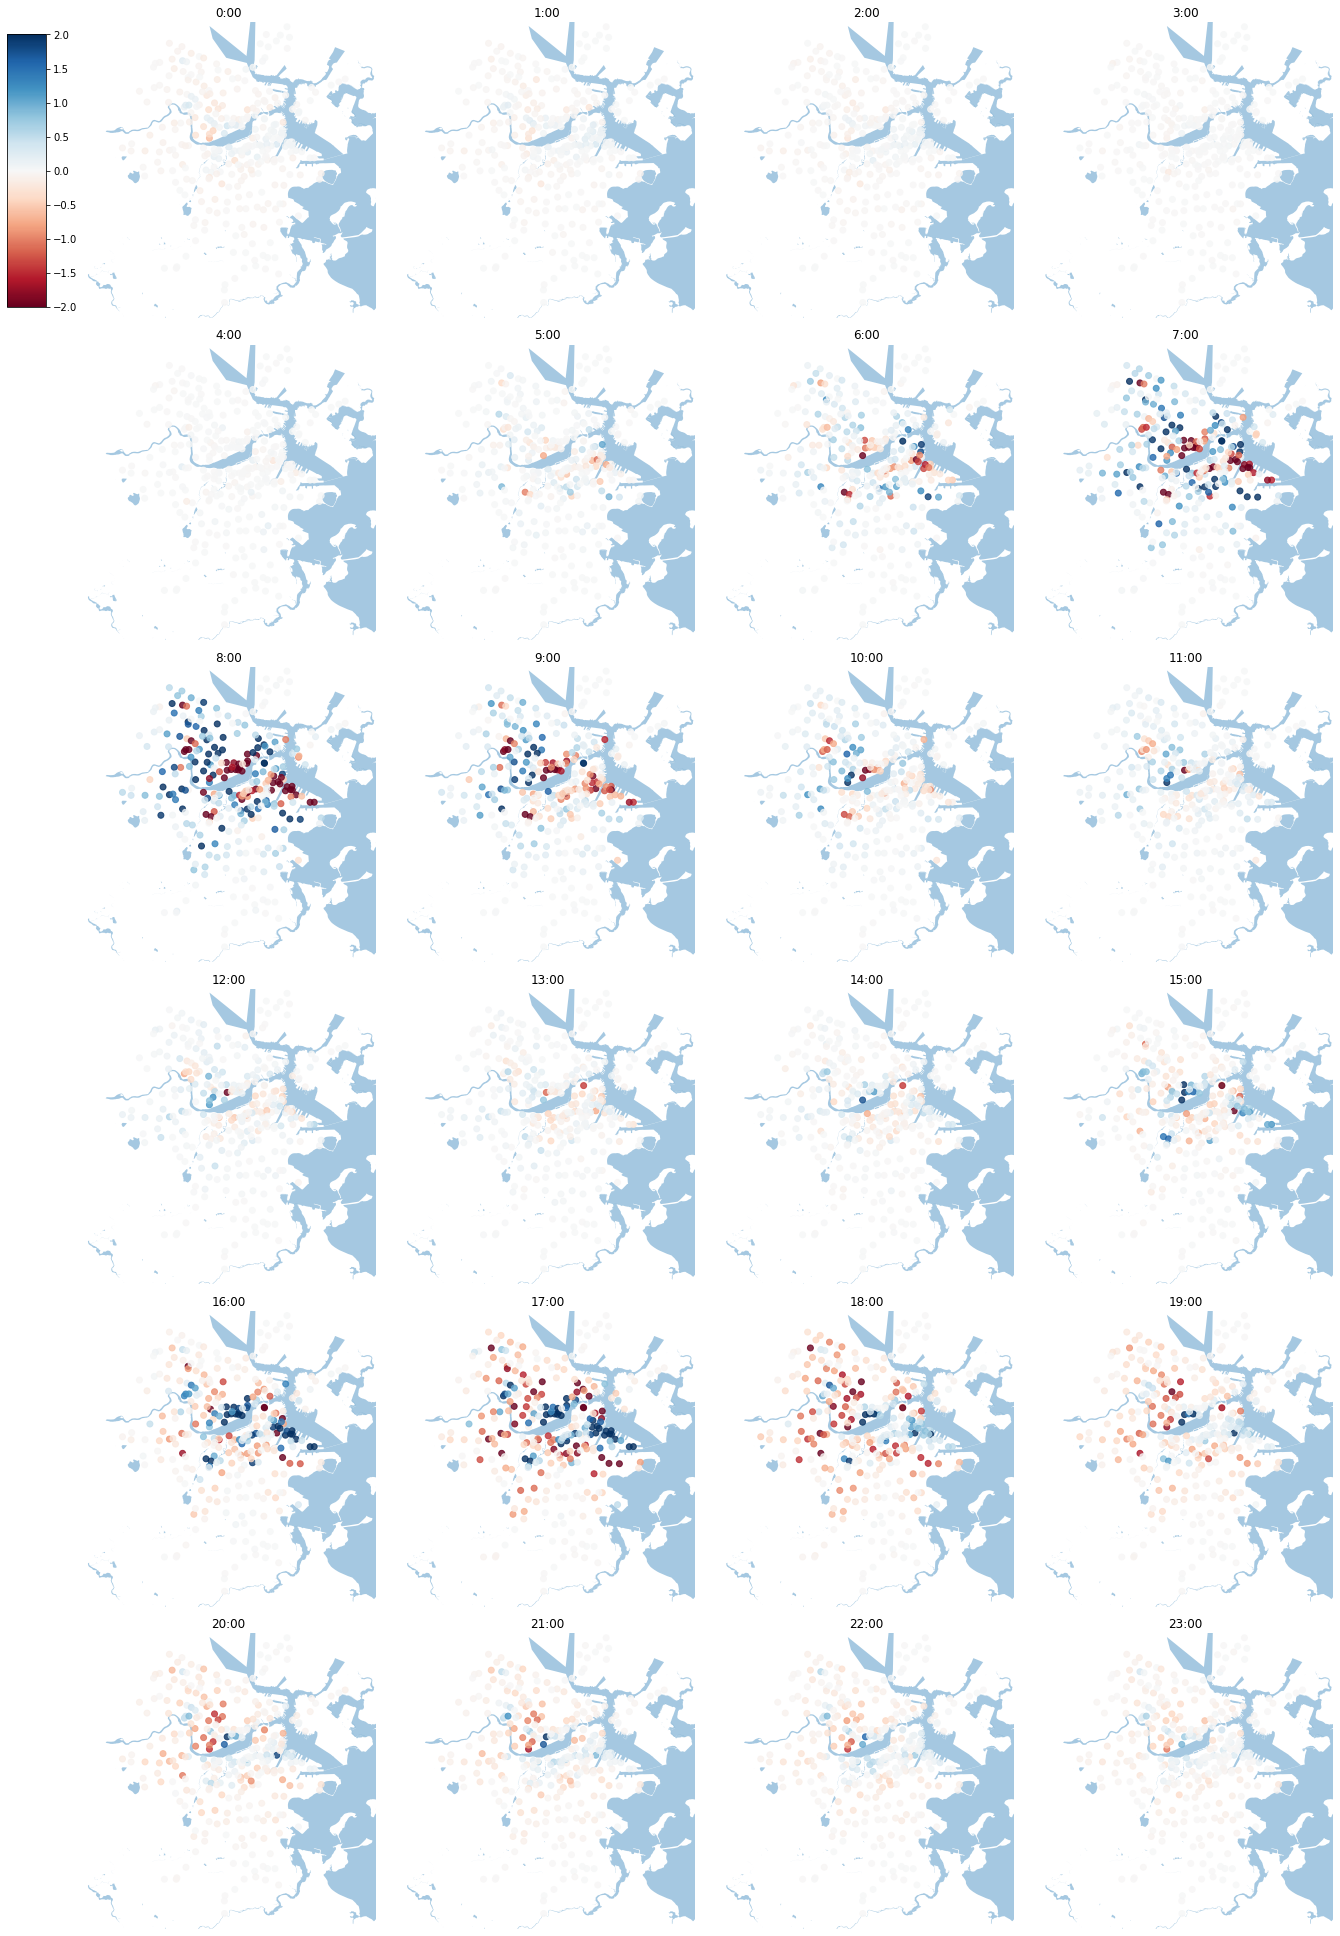

In [17]:
crs={'init':'epsg:4326'}

geometry=[Point(xy) for xy in zip(data.Longitude, data.Latitude)]
data_hour_geo=gpd.GeoDataFrame(data.merge(time_df, how="left", left_on="ID", right_on="ID"), crs=crs, geometry = geometry).to_crs(epsg=26986)

fig= plt.subplots(figsize=(18,27))
for i in range(24):
    ax = plt.subplot(6,4,i+1)
    ax.set_xlim([225000, 242500])
    ax.set_ylim([890000, 907500])
    waterpoly = gpd.read_file("../Data_raw/Shapefiles/Hydrography_Polygon_(1)/Hydrography_Polygon.shp").to_crs(epsg=26986)
    waterpoly.plot(ax=ax, alpha=0.4)

    data_hour_geo.plot(column =i, cmap="RdBu",vmin=-2, vmax=2, ax=ax, alpha=0.8)
    plt.title(str(i)+":00")
    plt.axis('off')


fig = ax.get_figure()
cax = fig.add_axes([-0.04, 0.84, 0.03, 0.14]) #left bottom width height
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=plt.Normalize(vmin=-2, vmax=2))
sm._A = []
fig.colorbar(sm, cax=cax)
    
plt.tight_layout()